# Tutorial Surprise UserKNN

En este práctico vamos a utilizar la biblioteca de Python [Surprise](http://surpriselib.com/) desarrollada por Nicolas Hug, para aprender sobre User KNN (Filtrado colaborativo basado en usuarios)

**Profesor**: Denis Parra

**Ayudantes**: Florencia Ferrer, Álvaro Labarca, Nicolás Sumonte, Jorge Facuse y Pablo Messina.


# Índice

>[Tutorial Surprise UserKNN](#scrollTo=NC-ceGb8LRLT)

>[Índice](#scrollTo=2j02H66f87eV)

>[Descargando la información](#scrollTo=9qKTQ2V5VKSX)

>[Revisar archivos descargados](#scrollTo=liJ3L2kl4g1o)

>>[Como ver la información de una o más películas](#scrollTo=jqXxj773Foo8)

>>[Preparar entorno](#scrollTo=P3K5VPZoGSYX)

>>[UserKNN](#scrollTo=2e0ZeZXzMhU3)

>>[Predecir el rating que le dará un usuario a un cierto item](#scrollTo=lEx2TVc1B5wk)

>>[Generar una lista de recomendaciones para un usuario](#scrollTo=dIVXNsQ8CCJV)

>>[Explorar los hiperparámetros del modelo UserKnn](#scrollTo=6_Kp3zRwJ9gv)

>>>[Evaluar en base a error de prediccion (RMSE y MAE)](#scrollTo=g55SDLmqCpUo)



## Configuración Inicial

Esta celda permite instalar una versión compatible de Numpy. Una vez que se pida reiniciar la sesión, no hay que volver a ejecutar esta celda.

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.25

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 6.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Descargando la información

Ejecutar cada celda presionando el botón de **Play** o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (OSX) para descargar las bases de datos

In [2]:
!pip install gdown


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
!gdown 1UQ8JimYWfj2z0BQISccTWGoirptyVIHU

In [ ]:
!gdown 1weLy5CTQiW8ltH24UsK5Y5451NFKNd_N

In [ ]:
!gdown 13afMOhZGgIKLz784biKbvZ1rnM4iJzLk

Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/).

### Revisar archivos descargados

Revisemos cómo es uno de estos archivos:

In [15]:
import pandas as pd

train_file = pd.read_csv('u1.base', sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [16]:
# Ver la o las filas específicas del item con id = 1653
train_file[train_file['itemid'] == 1653]

,userid,itemid,rating,timestamp
54444,675,1653,5,889489913


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo

In [17]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [24]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musical    

In [25]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.

## Como ver la información de una o más películas
Para esto se hace 2 pasos,
1. Determinar los índices de las películas
2. Pedir a `info_file` las columnas
3. (adicional) Indicar alguna columna en específico

In [26]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs

# Paso 1
pelis = [5,4,1]
# Paso 2
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Para éste código:
1. `pelis = [5,4,1]` indica que queremos las películas cuyo índice son 5, 4 y 1
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá como obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna

In [13]:
# Paso 3, acceder solo a columnas específicas
info_file.loc[pelis]['title']

,title
movieid,
5,Copycat (1995)
4,Get Shorty (1995)
1,Toy Story (1995)


## Preparar entorno
Primero es necesario instalar una librería para realizar recomendaciones. Esta se llama [***Surprise***](https://github.com/NicolasHug/Surprise)

In [ ]:
!pip install scikit-surprise --no-build-isolation --no-deps

Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en este práctico

In [ ]:
import surprise
import numpy as np
from collections import defaultdict

## UserKNN

Probar método de recomendación basado en ***UserKNN***

Antes de generar el recomendador, hay que convertir los datos a un formato que sea soportado por la librería Surprise. Para esto, utilizamos la función Reader que convierte una base de datos de un archivo al formato deseado.

In [ ]:
from surprise.model_selection import PredefinedKFold
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([("u1.base", "u1.test")], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

Se puede ver que al objeto Reader le estamos entregando:
* ***line_format:*** El orden de las columnas que representan cada elemento del dataset (debe tener el formato que se muestra y estar separadas por espacios).
* ***sep:*** El delimitador del archivo, en este caso las columnas estan separadas por un tab (\t)
* ***rating_scale:*** La escala usada en los ratings (en este caso los ratings van del $1$ al $5$)

Luego, usamos el módulo Dataset de Surprise para usar el objeto Reader para leer los datos de un archivo. En este caso, ya que tenemos el set de entrenamiento y testeo en archivos separados, usamos la función ***load_from_folds*** que recibe una lista de tuplas con los nombres de los archivos de entrenamiento y testeo. Existen también funciones que permiten leer todos los items de un solo archivo, cargar datasets predefinidos o importarlos desde un dataframe de Pandas. Pueden leer estas aplicaciones en la [_documentación_](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin).

Finalmente, la función ***pkf.split*** entrega un generador que itera sobre los archivos de entrenamiento y testeo que definimos en la lista que le entregamos a ***load_from_folds***. En este caso, como solo contamos con un archivo de entrenamiento y uno de testeo, invocamos la función ***next*** para definir los datasets como el primer output del generador.

Finalmente declaramos el objeto recomendador que vamos a usar:

In [4]:
# Declarar el objeto recomendador UserKnn
from surprise import accuracy
myUserKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': True})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [5]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myUserKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Predecir el rating que le dará un usuario a un cierto item

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37?



In [8]:
myUserKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=2.4420114287810444, details={'actual_k': 6, 'was_impossible': False})

## Generar una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando `loc` vista anteriormete)

Para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [9]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [10]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [11]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1347', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5), ('1189', 4.999999999999999)]


In [18]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1293,Star Kid (1997),16-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1347,"Ballad of Narayama, The (Narayama Bushiko) (1958)",01-Jan-1958,NaN,http://us.imdb.com/M/title-exact?Narayama%20Bu...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1656,Little City (1998),20-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Little+City+(...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Explorar los hiperparámetros del modelo UserKnn

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Usuarios), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

In [19]:
k_values = [5, 10, 30, 50, 70, 100] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0880
MAE:  0.8587
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0470
MAE:  0.8291
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0248
MAE:  0.8139
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8125
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0227
MAE:  0.8136
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0249
MAE:  0.8164
RMSE: [1.0880066691561228, 1.0470099288376837, 1.0248339991369078, 1.0223262772265247, 1.0226955364341241, 1.0249250212627894]
MAE: [0.8586799408942337, 0.8290726382845803, 0.8138754558513105, 0.8125053209390201, 0.8135933998242796, 0.8164173443106846]


### Evaluar en base a error de prediccion (RMSE y MAE)

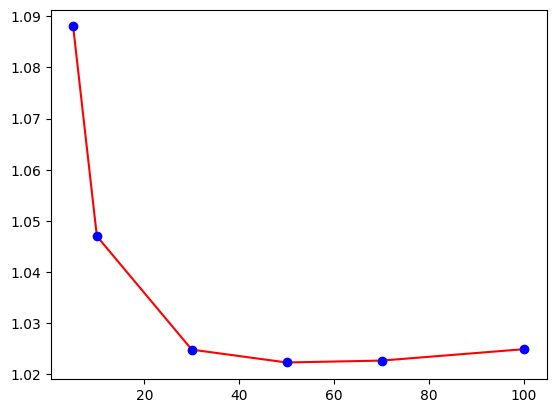

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

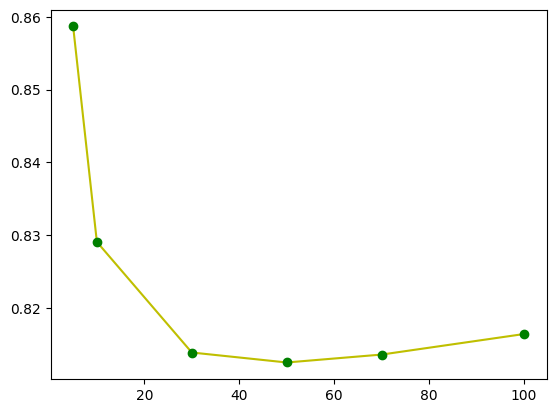

In [21]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.show()

**Ejercicio 1**

Según los resultados, ¿Qué numero de vecinos es mejor para hacer recomendaciones con un menor error de predicción? Muestre el top 10 de películas a recomendar al usuario de ID 457.

In [27]:
ganador = []
for k, rmse, mae in zip(k_values, rmse_values, mae_values):
    ganador.append((k, rmse, mae))
ganador.sort(key=lambda x: x[1])
print(f'Ganador RMSE: k={ganador[0][0]}')
ganador.sort(key=lambda x: x[2])
print(f'Ganador MAE: k={ganador[0][0]}')


Ganador RMSE: k=50
Ganador MAE: k=50


Segun los resultados el mejor valor de cantidad de vecinos que minimizan ambos errores es k = 50, por lo que se utilizara este valor para estimar las 10 mejores recomendaciones al usuario 457.

In [28]:
myUserKnn = surprise.KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': True})
myUserKnn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [29]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

In [30]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])
info_file.loc[[int(m[0]) for m in top_n["457"]]]

[('1122', 5), ('1201', 5), ('1293', 5), ('1175', 5), ('1467', 5), ('1189', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5)]


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1293,Star Kid (1997),16-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1175,Hugo Pool (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Hugo+Pool+(1997),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1189,Prefontaine (1997),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Prefontaine%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1656,Little City (1998),20-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Little+City+(...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [35]:
top_10_k7 = [('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1347', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5), ('1189', 4.999999999999999)]
top_10_k50 = [('1122', 5), ('1201', 5), ('1293', 5), ('1175', 5), ('1467', 5), ('1189', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5)]

contador = 0
for tupla in top_10_k7:
    if tupla in top_10_k50:
        print(f'La pelicula con id {tupla[0]} esta en ambas listas con rating estimado {tupla[1]}')
    else:
        print(f'La pelicula con id {tupla[0]} NO esta en la lista de k=50')
        contador += 1
print(f'Cantidad de peliculas que no estan en la lista de k=50: {contador}')

La pelicula con id 1122 esta en ambas listas con rating estimado 5
La pelicula con id 1201 esta en ambas listas con rating estimado 5
La pelicula con id 1293 esta en ambas listas con rating estimado 5
La pelicula con id 1467 esta en ambas listas con rating estimado 5
La pelicula con id 1347 NO esta en la lista de k=50
La pelicula con id 1599 esta en ambas listas con rating estimado 5
La pelicula con id 1653 esta en ambas listas con rating estimado 5
La pelicula con id 1656 esta en ambas listas con rating estimado 5
La pelicula con id 1500 esta en ambas listas con rating estimado 5
La pelicula con id 1189 NO esta en la lista de k=50
Cantidad de peliculas que no estan en la lista de k=50: 2


En conclusión al optimizar el parametro de vecinos se lograron mejores recomendaciones, ya que todas las peliculas que se recomendarón tenian una prediccion de 5, en vez con 7 vecinos la ultima pelicula tenia un rating de 4.999999999999999, lo cual es casi 5 pero sigue siendo peor. De todas formas en una aplicación real con muchos usuarios tal vez se puede sacrificar un menor error por una mayor rapidez del algoritmo.